# Report Basics of Mobile Robotics - 2024

## Table of Contents
0. [Introduction](#Introduction)
1. [Setup](#Partie-1-:-Setup)
    - 1.1 : Physical setup
    - 1.2 : Code setup
2. [Initial tuning](#Partie-2-:-Initial-tuning)
    - 2.1 : Wheel speed (differential)
3. [Vision](#Partie-2-:-Vision)
    - 3.1 : Dynamic lighting adaptation
    - 3.2 : Aruko markers
        - 3.2.1 : Thymio and goal
    - 3.2 : Map resizing
4. [Kalmann](#Partie-3-:-Kalmann)
    - 4.1 : Theory
    - 4.2 : Implementation
5. [Global path planning](#Partie-4-:-Global-path-planning)
    - 5.1 : Dijkstra
    - 5.2 : References
6. [Local navigation](#Partie-5-:-Local-navigation)
    - 6.1 : Local obstacle detection
    - 6.2 : Potential fields
7. [Motion control](#Partie-5-:-Motion-control)
    - 7.1 : Differential drive
    - 7.2 : Astolfi
    - 7.3 : References
8. [Demonstrations](#Partie-5-:-emonstrations)
9. [Conclusion](#IConclusion)
---



## Introduction
Authors : Tifaine Mezencev, Julien, Zhuoran, Christy

A small but determined vessel navigating uncharted waters, its sights set on a glittering treasure at the far edge of the map. Along the way, it must skillfully avoid perilous islands and evade the watchful patrols of navy ships.

In this project, we implement global and local navigation for the Thymio robot. The goal is to enable the robot to plot an optimal course toward its destination while dynamically avoiding both static and unexpected obstacles. The key features of our implementation include:

- Accurate map creation and feature localization using ArUco markers
- Global pathfinding using Dijkstra's algorithm
- Seamless connection to the Thymio robot for real-time path execution
- Path-following with dynamic adjustment for precision navigation
- Emergency handling, including "Thymio kidnapping" detection and recovery
- Local obstacle avoidance with a potential field method
- Robust navigation supported by a Kalman filter in the absence of camera input


---



## 1 : Setup

### 1.1 : Physical setup






### 1.2 : Code setup

## 2 : Initial tuning

### 2.1 Wheel speed (differential)

## 3: Vision

The Vision.py module has two tasks : run the camera and analyse the frames captured by the camera. This is why the Vision class is actually more of a wrapper around the functionnalities given by the two other classes defined in the vision file, appropriately named Analysis and CameraFeed. 


Let's dive into Analysis.
 
Given an image, the class has three tasks : pinpoint the thymio, the goal, and the 2D (black) obstacle in a consistent reference frame.  Of course doing this is easier said than done. A getter function of Vision will then be used to access these values and pass them on to the other modules.
The first step is defining what is in the map and what is outside the map.


### 3.1 Map

We first wanted to use color to differenciate the components of our problem and we painted our map in blue and obstacles in black. Specifically, we tried using a blue color mask to make out the map and pinpoint its four corners. This was relavitely inconsistent however, and we decided to use ArUco markers to make our life easier.

### 3.1 : ArUco markers
ArUco markers are binary patterns which are unique and have no symmetry. Due to this, they are often used in robotics and computer vision because seeing one markers makes it possible to completely determine the orientation of the camera relative to the marker (and its distance, if the size of the marker is known). They are implemented in the very convenient  ```aruco``` library which implements most of the code needed to detect the markers and the according translation and rotation transform matrices.

We have 6 markers : one per map corners, and two for the goal and thymio. Each marker is unique, and ```aruco```.detectMarkers() returns the detected marker's corners along with their ids. 


### 3.2 : Map resizing
It is easier for us if the image is a perpendicular top-down view and everything that isn't part of the map is cropped out. To achieve this, we apply some a four-point transformation on the image. First we find the four corners of the map with our aruco markers We are lucky because opencv provides us with great tools (getPerspectiveTransform and warpPerspective) to do this.

In [ ]:
def four_point_transform(self, image, pts):
        # obtain a consistent order of the points and unpack them
        # individually''
        (tl, tr, br, bl) = pts.astype('int32')

        #get fixed resized image dimensions
        maxWidth, maxHeight = self.map_size
        
        # construct the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
    
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(pts.astype('float32'), dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        # warped = cv2.putText(warped, f"{maxWidth} x {maxHeight}", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)
        self.highlight_corners(warped, dst)
        # return the warped image
        return warped, M

Since it eliminates all problems due to perspective or elements outside of the map confusing our analysis, the obstacles, goal and thymio are detected on the resized/warped image. This also has the advantage that we can directly give the pixel coordinates of the different features to our path planner. <br> 
Indeed on the untransformed image, the same distance in pixel reprenseents different distances in centimeters if the distance and angle of the camera relative to the map. But since the resized image has fixed dimension (600x300), the distance metric is consistent : (0,0) always corresponds to the top-left corner of the map, (300,150) to the center point, etc.


### 3.4 Thymio and goal detection
We once again detect the ArUco markers on the resized image, and use a function that we wrote ourselves to find their center point and 2D orientation (defineed as angle between marker top edge and image X-axis) based on the corner points of each marker. 
Yes, the aruco library already implements a translation and rotation transform matrix, yes we forgot to read the docs before starting. But it's okay, it was a fun little geometry puzzle to solve. 

### 3.5 : Global obstacle detection

The function ```detect_obstacle_corners``` detects obstacles in an image by analyzing its brightness levels dynamically, regardless of ambient light conditions.
It segments the image into obstacle regions (dark areas) and background (lighter areas) using a dynamically calculated threshold. The processed image is then used to extract the obstacle corners, which are needed to compute the Dijkstra path for the Thymio.
The process is robust to variations in ambient lighting, as it adapts based on the image's brightness distribution.

This code works as follow :
- **Image Preprocessing:**
The image is converted to the LAB color space, isolating the L (lightness) channel for analysis. This way, color differences are ignored, and only variations in luminosity (black obstacles vs. the shadows of our objects and the lighter background) are considered.

- **Histogram Analysis:**
A histogram of brightness values is calculated from the L channel. After smoothing the data with a median filter, its gradient is calculated and used to identify sharp transitions between dark and bright regions *(green dashed line in the middle image)*.
A dynamic threshold is chosen at the point where the gradient is steepest, which represents the boundary between obstacles and background.
    
- **Segmentation:**
Pixels below the threshold computed before are classified as "obstacle regions" and form a binary mask that can be seen in the right image.

- **Post-processing:**
The binary mask is cleaned using size filtering to remove noise, and morphological operations like *dilation* and *erosion* are applied to refine the shapes. They smooth the edges of obstacles while preserving the relevant regions to make it easier to detect the edges later.
    - Dilation expands object boundaries, filling small gaps or holes.
    - Erosion shrinks object boundaries, removing noise or small irregularities on the edges. <br>


In [ ]:
def detect_obstacle_corners(self, img):
    """
    Detects obstacle edges in the image, approximates them as polygons, 
    and keeps only those with an average color that resembles black (obstacles).
    Returns three outputs: the polygons, the binary obstacle mask, and the image with visualized polygons.
    """
    # 1. Convert the image to LAB color space for color analysis
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 2. Calculate the histogram of the L component
    hist = cv2.calcHist([lab_img[:, :, 0]], [0], None, [180], [0, 180])  # 180 bins for L in the range [0, 180]
    signal = np.gradient(medfilt(hist.flatten(), 15))  # Median filtering to smooth the signal

    grad_threshold = -10
    highest = 125

    # 3. Search for the threshold in the signal
    crossing_index = -1
    for i in range(highest - 1, 1, -1):  # Start just below 'highest' and move backwards
        if signal[i] < grad_threshold:
            crossing_index = i
            break
        
    treshold = crossing_index

    # 4. Create a binary mask based on the threshold
    mask = lab_img[:, :, 0] < treshold
    obstacles = np.uint8(mask * 255)

    # 5. Process connected components
    COUNT = 3000  # Minimum size threshold for components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(obstacles, connectivity=8)
    filtered_mask = np.zeros_like(obstacles)

    for i in range(1, num_labels):  # Ignore background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= COUNT:
            filtered_mask[labels == i] = 255

    # 6. Morphological operations to smooth the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Structuring element for dilation
    filtered_mask = cv2.dilate(filtered_mask, kernel)
    filtered_mask = cv2.erode(filtered_mask, kernel)

    # 7. Find contours of the obstacles
    contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 8. List to store the corners of the obstacles
    obstacle_corners = []

    # 9. Approximate the contours as polygons
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Approximation precision
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Add the corners of the polygons
        obstacle_corners.append(approx.reshape(-1, 2).tolist())

    # 10. Visualize the polygons with colored edges and circles at corners
    img_with_polygons = img.copy()

    # Assign a unique color for each polygon
    for i, polygon in enumerate(obstacle_corners):
        # Random color for each polygon (BGR format)
        color = np.random.randint(0, 256, 3).tolist()

        # Draw the corners as red circles
        for (x, y) in polygon:
            cv2.circle(img_with_polygons, (x, y), 5, (0, 0, 255), -1)  # Red circles at corners

        # Draw the polygon edges
        polygon_array = np.array(polygon, dtype=np.int32)
        cv2.drawContours(img_with_polygons, [polygon_array], -1, color, 2)  # Polygon edges with random color

    # 11. Return the results: obstacle corners, binary mask, and image with visualized polygons
    return obstacle_corners, filtered_mask, img_with_polygons

Dynamic calculation of the light threshold to differentiate obstacles from the rest is done by identifying a ‘threshold’ based on the slope (gradient) of the histogram, after smoothing the data with a median filter.

```hist = cv2.calcHist([image[:,:,0]], [0], None, [180], [0, 180])``` <br>
```signal = np.gradient(medfilt(hist.flatten(), 15))``` <br>

In LAB space, L is typically represented in the range [0.100], but OpenCV extends this range to [0.255]. 
After testing in different environments, we realised that the frequency variation of values above 180 is close to 0. We therefore found it appropriate not to display/analyse values above 180, which gives us a more accurate histogram, with the range of L divided into 180 *(bins)* intervals.

The threshold itself is then detected when there is a sharp drop in the luminosity distribution ```grad_threshold = -10```, indicating a marked transition in the image between darker and lighter areas.

The value ```highest = 125``` sets an upper limit for analyzing the histogram gradient, focusing the search on darker intensities (below 125) to identify significant drops, which are more likely to separate dark objects from the background. This avoids taking into account the little fluctuations in high levels of luminosity.


After applying the morphological transformations of *erosion* and *dilation*, we can then detect the edges and approximate the resulting shapes as polygons using the CV2 functions: ```cv2.findContours``` and ```cv2.approxPolyDP```

### 3.7 Camera management 
We want the camera to always be running in the background and display the video feed continously (along with whichever debugging displays), independently of what the path planner, control or kalman modules are doing. 

This is why we use the ```threading``` library, which allows different processes to be run in parallel. The CameraFeed class inherits from the ```threading```.Thread class. 
Its core method is a while loop that captures a frame, finds its corners, resizes it, detects the Thyimio & goal and (if desired) draws and shows the debugging displays. 

At the start of the code, the begin() method of the Vision class initializes and runs a CameraFeed thread object, which will continue its work in the background for the rest of the program.

## 4 : Kalmann filter

In our implementation, there are situations where the camera may be obstructed or go offline. In such cases, the camera measurements become less reliable, so we switch to using the motor sensors to estimate the robot's state. While the motor sensors may not provide the same level of accuracy, they serve as a reliable backup option. To integrate all sensor data effectively, we use a Kalman filter, which allows us to combine the information from both sensors to provide a more accurate and robust estimation of the robot’s state.

### 4.1 : Theory

In the real model, there is noise present both in the state transition model and in the measurement model, as shown in the formulation below:

$$
x_k = F_kx_{k-1} + B_k u_k + w_k
$$
$$
z_k = H_kx_k + v_k
$$

For our Thymio robot, the $\omega _k$ represents the mechanical error of the wheel motors, while 
$v _k$ refers to the measurement error caused by the camera we use. To implement the Kalman filter, we follow two main steps: the prediction step and the update step.

In the prediction step, we predicts the state of the system and the associated uncertainty based on the previous state estimate.
$$
\hat{x}_{k|k-1} = F_k\hat{x}_{k-1|k-1} + B_k u_k
$$
$$
P_{k|k-1} = F_kP_{k-1|k-1}{F_k}^T + Q_k
$$
In the update step, we incorporate the actual measurement into the prediction to update the state estimte.
$$
\tilde{y}_k = z_k - H_k\hat{x}_{k|k-1}
$$
$$
S_k = H_kP_{k|k-1}{H_k}^T + R_k
$$
$$
K_k = P_{k|k-1}{H_k}^T{S_k}^{-1}
$$
$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k\tilde{y}_k
$$
$$
P_{k|k} = (I - K_kH_k)P_{k|k-1}
$$

### 4.2 : Implementation

Since our system is nonlinear, we need to linearize it before applying the extended Kalman filter. We update our robot's state at a very high frequency, which allows us to use a simple linearization method. During such small time intervals, we assume that the Thymio moves in a straight line, thus we get our state transition matrix as below:

$$
\begin{bmatrix}x_{k}\\ y_{k} \\ \theta_{k}\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}\begin{bmatrix}x_{k-1} \\ y_{k-1} \\ {\theta}_{k-1}\end{bmatrix}+
\begin{bmatrix}
cos\theta / 2 & cos\theta / 2  \\
sin\theta / 2 & sin\theta / 2 \\
1 / 2L & -1 / 2L
\end{bmatrix}
\begin{bmatrix}\Delta s_l \\ \Delta s_r \end{bmatrix} + \omega _k
$$

As for the measurement model, we directly get the robot's state from the camera, so we could simply set $H$ to be a identity matrix, as show below:

$$
z_k = H_kx_k +v_k
$$
in which:
$$
H = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

The whole implementation function is as below:

In [ ]:
def estimate(self, vl, vr, measurement):
    measurement = np.array(measurement)
    u = np.array([vl, vr])
    A = self.A
    print("change something")
    B = np.array([[np.cos(self.kal_state[2]) / 2, np.cos(self.kal_state[2]) / 2],
                      [np.sin(self.kal_state[2]) / 2, np.sin(self.kal_state[2]) / 2],
                      [1 / (2 * self.L), - 1 / (2 * self.L) ]])
    est_state = A @ (self.kal_state) + B @ u
    est_variance = A @ (self.kal_variance @ A.T) + self.Q
    yk = measurement - self.H @ est_state
    self.S = self.H @ (est_variance @ self.H.T) + self.R
    self.K = est_variance @ (self.H.T @ np.linalg.inv(self.S))
    self.kal_state = est_state + self.K @ yk
    self.kal_variance = (np.eye(3) - self.K @ self.H) @ est_variance
    return self.kal_state, self.kal_variance

## 5 : Global path planning
 


One of the major tasks the robot had to achieve in this project, is being able to navigate in a fixed map with fixed obstacles. This is refered to as "Global Navigation".
 
How is it implemented?

### 5.1 : Dijkstra

After receiving the list of obstacle vertices from the camera, the Thymio's actual position, which represents our start point; and the goal point, we will be able to compute the optimal path our robot has to follow to achieve the end position.

First, we have to increase the margin of our vertices as to account for the radius and size of our robot. To do so, we used the ```geopandas```  and ```shapely``` library, which can be found using these two links respectively:  
- https://geopandas.org/en/stable/
- https://shapely.readthedocs.io/en/stable/




In [ ]:
from shapely.geometry import LineString, Polygon
from geopandas import GeoSeries

class GlobalNavigation:

 def __init__(self):
  self.margin = 40
  self.last_thymio = None
  self.last_goal = None
            
            

 def getObstacles(self, start, goal, obstacles):
  obstacle_polygons = [Polygon(vertices) for vertices in obstacles]
  buffered_obstacles = (GeoSeries(obstacle_polygons)).buffer(self.margin, join_style = 2)
  all_vertices = [tuple(start), tuple(goal)]
  for buffered_obstacle in buffered_obstacles:
            for coord in buffered_obstacle.exterior.coords:
                all_vertices.append(tuple(coord))
  return obstacle_polygons, all_vertices

Once the new coordinates were computed, we will contruct our visibility graph by feeding both obstacle_polygons list and all_vertices list into our function. Lines will be generated to join every vertice with the other, with the sole condition that this line does not interfere with any obstacle. The is_valid_edge checks whether these lines collide with the buffered obstacles.

In [ ]:
def is_edge_valid(self, p1, p2, obstacles):
  edge = LineString([p1, p2])
  for obstacle in obstacles:
   if edge.crosses(obstacle) or edge.within(obstacle):
    return False
  return True

def visibilityGraph(self, start, goal, obstacles):
  obstacle_polygons, all_vertices = self.getObstacles(start, goal, obstacles)
  visibility_graph = {v: [] for v in all_vertices}
  for i, v1 in enumerate(all_vertices):
   for j, v2 in enumerate(all_vertices):
    if i != j and self.is_edge_valid(v1, v2, obstacle_polygons):
     visibility_graph[v1].append(v2)
  return visibility_graph

Therefore, the Dijkstra algorithm can be computed from the results of the above functions. As shown in the snippet below, the function takes three parameters: the Thymio's state, the goal coordinates, and the obstacle list. However, what is actually the Dijkstra algorithm?

Dijkstra's algorithm finds the shortest path between a start point and a goal in a graph by exploring nodes in order of increasing distance. Starting at the initial point(Thymio's position) with a distance of 0, it updates distances to neighboring nodes if a shorter path is found, using a priority queue for efficiency. This process continues until the goal is reached or all nodes are visited. In the provided code, the algorithm will return the path, represented by a list of point coordinates, the distance to the path, and the graph computed by the visibility graph function. 

In [ ]:
import heapq
import numpy as np

def dijkstra(self, thymio, goal, obstacles):

     #if we don't detect goal or thymio, use last saved position
    if thymio == [] or thymio is None:
        print(0)
        if self.last_thymio is None: #was never found, still initialized as None
           return None, 0, None
        thymio = self.last_thymio
    else:
         #if we have new thymio position, update it
       self.last_thymio = thymio

    if goal == [] or goal is None:
       if self.last_goal is None:  #was never found, still initialized as None
          return None, 0, None 
       goal = self.last_goal
    else:
       self.last_goal = goal
       
       
    try :
        thymio_x, thymio_y, theta = thymio
    except : 
       print("Qu'estce a direque ceci",type(thymio), thymio)
       thymio_x, thymio_y, theta = thymio

    start = (thymio_x, thymio_y)
    goal = tuple(goal)
    obstacles = [tuple(obstacle) for obstacle in obstacles]

    graph = self.visibilityGraph(start, goal, obstacles)
    queue = [(0, start)]  # (cost, current_node)
    distances = {node: float("inf") for node in graph}
    previous_nodes = {node: None for node in graph}
    distances[start] = 0

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        # If we've reached the goal, reconstruct the path
        if current_node == goal:
            path = []
            while current_node:
                path.append(tuple(float(coord) for coord in current_node))
                current_node = previous_nodes[current_node]
            return path[::-1], current_distance, graph  # Return reversed path and distance

        # Check all neighbors
        for neighbor in graph[current_node]:
            edge_distance = np.linalg.norm(np.array(current_node) - np.array(neighbor))
            new_distance = current_distance + edge_distance

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(queue, (new_distance, neighbor))

    return None, float("inf"), graph  # Return None if no path is found

Below is a small example of how our algorithm works. You could change the coordinates of the start and goal points and hence, visualize how the path changes for the fixed map.

0    POLYGON ((115.683 739.391, 382.159 742.385, 31...
1    POLYGON ((865.185 463.438, 718.908 742, 1045.8...
2    POLYGON ((-12.759 373.856, 28.426 477.481, 105...
3    POLYGON ((1012.552 21.908, 957.976 246.019, 12...
4    POLYGON ((318.14 -20, 280.055 142.727, 367.633...
dtype: geometry


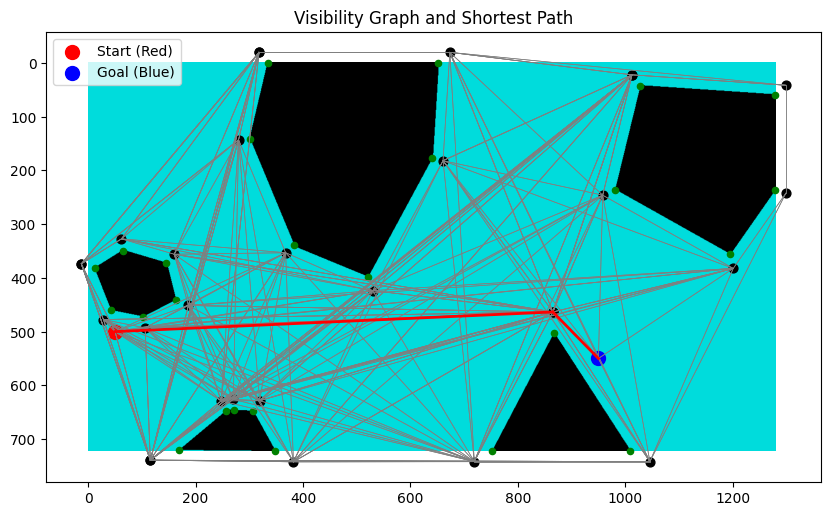

Shortest Path: [(50, 500), (865.1845457845262, 463.4384667067322), (950, 550)]
463.4384667067322
Path Distance: 937.1921571633495
Visibility graph:  {(50, 500): [(115.6828566230361, 739.3909574452535), (319.14012342615274, 628.6436108822086), (270.2262425694945, 625.9261730568387), (247.6080873259704, 628.9419270893086), (115.6828566230361, 739.3909574452535), (865.1845457845262, 463.4384667067322), (718.9079415437692, 742.0), (865.1845457845262, 463.4384667067322), (-12.758508151759882, 373.85568805103844), (28.42602303991701, 477.48128266235454), (105.95206597976693, 492.9864912503245), (186.5874700985093, 451.32486578897425), (-12.758508151759882, 373.85568805103844), (1201.0051126306118, 382.2971408583652), (367.63326900949653, 353.1273973154062), (529.8633802226836, 423.6622282776615)], (950, 550): [(865.1845457845262, 463.4384667067322), (1045.8043527600698, 742.0), (865.1845457845262, 463.4384667067322), (957.9756587317696, 246.01894241041632), (1201.0051126306118, 382.297140858

In [ ]:
import cv2
import numpy as np
from shapely.geometry import LineString, Polygon
from PIL import Image
from shapely import affinity
import matplotlib.pyplot as plt
import heapq
import geopandas as gpd
from geopandas import GeoSeries



image_path = r"C:\Users\User\MICRO452_Mobile_Robots\Photos\Image_after_processing.png" 
image_cv = cv2.imread(image_path)

gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

margin = 20


# Detect contours and approximate polygon vertices
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
vertices_list = []
for contour in contours:
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    vertices_list.append(approx.reshape(-1, 2))


start_point = (50, 50)  
goal_point = (950, 550)  

# Create obstacles as polygons
obstacle_polygons = [Polygon(vertices) for vertices in vertices_list]

g = (GeoSeries(obstacle_polygons)).buffer(margin, join_style = 2)

print(g)

# Combine all vertices
all_vertices = [start_point, goal_point] 
# + [tuple(v) for vertices in vertices_list for v in vertices]

# m = 2

# for obstacle in g:
#    j = 0
#    while j < len(obstacle.exterior.coords) - 1:
#         all_vertices[m] = obstacle.exterior.coords[j]
#         j = j + 1
#         m = m + 1
for buffered_obstacle in g:
            for coord in buffered_obstacle.exterior.coords:
                all_vertices.append(tuple(coord))


# Function to check if an edge is valid, doesn't cross obstacles
def is_edge_valid(p1, p2, obstacles):
    edge = LineString([p1, p2])
    for obstacle in obstacles:
        if edge.crosses(obstacle) or edge.within(obstacle):
            return False
    return True

def visibilityGraph(all_vertices):
    visibility_graph = {v: [] for v in all_vertices}
    for i, v1 in enumerate(all_vertices):
        for j, v2 in enumerate(all_vertices):
            if i != j and is_edge_valid(v1, v2, obstacle_polygons):
                visibility_graph[v1].append(v2)
    return visibility_graph

# Implement Dijkstra's Algorithm
def dijkstra(graph, start, goal):
    queue = [(0, start)]  # (cost, current_node)
    distances = {node: float("inf") for node in graph}
    previous_nodes = {node: None for node in graph}
    distances[start] = 0

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        if current_node == goal:
            path = []
            while current_node:
                path.append(current_node)
                current_node = previous_nodes[current_node]
            return path[::-1], current_distance

        for neighbor in graph[current_node]:
            edge_distance = np.linalg.norm(np.array(current_node) - np.array(neighbor))
            new_distance = current_distance + edge_distance

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(queue, (new_distance, neighbor))

    return None, float("inf")

visibility_graph = visibilityGraph(all_vertices)
shortest_path, path_distance = dijkstra(visibility_graph, start_point, goal_point)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.title("Visibility Graph and Shortest Path")


for vertices in vertices_list:
    for (x, y) in vertices:
        plt.scatter(x, y, c="green", s=20)  # Vertices

for x,y in all_vertices:
   
        plt.scatter(x, y, c="black", s=40)

for v1, neighbors in visibility_graph.items():
    for v2 in neighbors:
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], c="gray", linewidth=0.5)

if shortest_path:
    for i in range(len(shortest_path) - 1):
        x1, y1 = shortest_path[i]
        x2, y2 = shortest_path[i + 1]
        plt.plot([x1, x2], [y1, y2], c="red", linewidth=2)

plt.scatter(start_point[0], start_point[1], c="red", s=100, label="Start (Red)")
plt.scatter(goal_point[0], goal_point[1], c="blue", s=100, label="Goal (Blue)")

plt.legend()
plt.axis("on")
plt.show()

print("Shortest Path:", shortest_path)
print(shortest_path[1][1])
print("Path Distance:", path_distance)
print('Visibility graph: ', visibility_graph)


### 5.2 : References

For the integration of this part, we used the listed references to guide us more into our work. However, note that the full code was all written by ourselves, taking into account the information provided by the following referenced websites:
- https://www.geeksforgeeks.org/dijkstras-shortest-path-algorithm-greedy-algo-7/
- https://stackoverflow.com/questions/57702870/how-could-i-add-a-safe-zone-around-my-obstacles-or-around-my-robot
- https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
- https://chatgpt.com
- Exercise session in class

## 6 : Local navigation

### 6.1 : Local obstacle detection

In [ ]:
def is_obstacle(self, prox_horizontal):
    
    mark = 0
    for i in range(5):
      if prox_horizontal[i] > self.threshold_high:
        return 1
      if prox_horizontal[i] < self.threshold_low:
        mark = mark + 1
    if mark == 5:
      return 0
    else:
      return 1

### 6.2 : Potential fields

This function enables local navigation by adjusting the robot's motor speeds to avoid obstacles based on proximity sensor readings.

In [ ]:
def obstacle_avoidance(self):
    speed = self.get_motor_speed()
    prox_horizontal = self.read_prox_sensors()
    while self.is_obstacle(prox_horizontal):
      delta = 0
      for i in range(5):
        delta += prox_horizontal[i] * self.obstSpeedGain[i]
      delta = max(-self.max_omega, min(delta, self.max_omega))
      speed[0] = speed[0] + delta
      speed[1] = speed[1] - delta
      speed[0] = int(speed[0])
      speed[1] = int(speed[1])
      self.thymio.set_motor_speed(speed[0], speed[1])
      speed = self.get_motor_speed()
      prox_horizontal = self.read_prox_sensors()

## 7 : Motion control

For the final part of our project, we had to control the wheels' speed of the Thymio so as to follow the computed path in a smooth and precise manner.

### 7.1 : Differential drive

As mentioned in class, the Thymio is a differential drive robot, hence, it has three degrees of freedom represented by its position (x,y) and orientation (theta). The only two DOF that are directly acessible are its linear and angular speed.

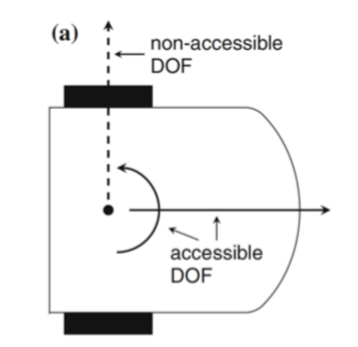

Therefore, we had to implement a controller for both wheels' speed V_l and V_r:
- If both positive and equal, the robot moves forward.
- If both negative and equal, the robot moves backward.
- If opposite signs, the robot rotates.

### 7.2 : Astolfi

Many types of control methods could be used for this type of application. We decided to implement the Astolfi controller visited in class.

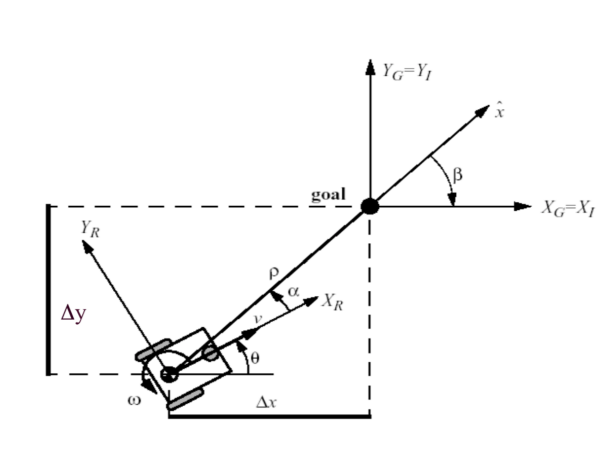

This type of controller is designed to track a desired trajectory and move towards a target goal. It regulates the linear and angular velocities based on the error in the current and desired position and orientation of the robot.
From the above picture representing the robot's kinematic model, a set of equations were developed to achieve the desired parameters.

$$
  distance = \sqrt[2]{\Delta x^2+\Delta y^2}

$$ (my_other_label)
$$
  \alpha = - \theta + \arctan(\Delta y, \Delta x)

$$ (my_other_label)
$$
  \beta = - \theta -\alpha

$$ (my_other_label)
$$
  v = K_p * distance

$$ (my_other_label)
$$
  \omega = K_\alpha * \alpha +  K_\beta * \beta

$$ (my_other_label)

After tuning, we set $ K_p = 20, K_\alpha = 50, K_\beta = 0 $

Also, we set a high linear speed for the wheels when the goal is too far and a lower speed when the goal is getting close. Once we reach a very close distance to the goal, we set the speed of the wheels to only be function of the angular velocity, since at each goal vertex, the orientation of the thymio needs to change.

In [ ]:
import numpy as np
from robot_api import Thymio
from tdmclient import ClientAsync
import time
class MotionControl:
  '''
  Control method: Astolfi Control for Differential Drive Robots
  '''
  def __init__(self, thymio):
    # important parameter to adjust
    self.Ka = 50
    self.Kb = 0
    self.Kp = 20

    # units: mm
    self.wheel_radis = 20
    self.L = 95

    # robot interface
    self.thymio = thymio

    # parameters related to global navigation
    self.goal_range = 30

    self.start_time = None
    self.end_time = None


def path_tracking(self, robot_state, goal_point):
    if self.start_time is None:
      self.start_time = time.time()
    x, y, theta = robot_state
    
    theta = -theta
    print("theta = ", theta)
    x_goal, y_goal = goal_point
    delta_x = x_goal - x
    delta_y = y_goal - y
    distance_to_goal = np.sqrt(delta_x ** 2 + delta_y ** 2)
    self.distance_to_goal = distance_to_goal
    
    angle_to_goal = np.arctan2(-delta_y, delta_x)
    
    alpha = - theta + angle_to_goal
    beta = - (theta + alpha)

    if(alpha > np.pi):
      alpha = alpha - 2 *np.pi
    elif (alpha < -np.pi):
      alpha = alpha + 2 * np.pi

    v = self.Kp * self.distance_to_goal
    omega = self.Ka * alpha + self.Kb * beta

    if(self.distance_to_goal > 500):
      v = 250 * self.wheel_radis
    if(self.distance_to_goal < 50):
      v = 100 * self.wheel_radis
    if(self.distance_to_goal < self.goal_range):
      v_L = int((self.L * omega / 2) / self.wheel_radis)
      v_R = int((self.L * omega / 2) / self.wheel_radis)

      self.set_motor_speed(v_L, v_R)
      return True
    
    v_L =  int((v - (self.L * omega / 2)) / self.wheel_radis)
    v_R = int((v + (self.L * omega / 2)) / self.wheel_radis)

    self.set_motor_speed(v_L, v_R)
    return False

### 7.3 : References

For the integration of this part, the following resources were used:
- Class slides
- https://www.youtube.com/watch?v=14xipN7Gx-I
- https://eprints.uad.ac.id/30303/1/1%20Muhammad%20Auzan,%20Path%20Tracking%20and%20Position%20Control%20of%20Nonholonomic%20Differential%20Drive%20Wheeled%20Mobile%20Robot.pdf
- https://github.com/theoh-io/EPFL_MobileRobotics_2021

## 8 : Demonstrations

---
## 9 : Conclusion
---



# 10 : Notes

## 10.1 References
Here are the references to webpages, repositories and other resources from which we took code segments or inspiration.


#### Vision.py
*(lines 282-306) four_point_transform()*: This method was based on https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/ and https://evergreenllc2020.medium.com/building-document-scanner-with-opencv-and-python-2306ee65c3db 

*(lines 197-206) detect_aruco()* : based on code snippets from https://stackoverflow.com/questions/77590669/drawmarker-in-cv2-aruco-not-found 
and https://stackoverflow.com/questions/74964527/attributeerror-module-cv2-aruco-has-no-attribute-dictionary-get 



